In [1]:
import pymc3 as pm
import theano.tensor as T
from theano.compile.ops import as_op
import theano

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

# Bayesian Network Models in PyMC3 and NetworkX
## Taken from PMML 4.3

We start with a simple network having several continuous and several discrete (categorical) distributions. We have to define the conditional probabilities for each case in the categorical nodes. 

<img src="http://dmg.org/pmml/v4-3/BNExampleModel.png" alt="alt text" width="400" height="400" align="left">

$D_1$   | Probability
-----|-------
0	 |    0.3
1    |	  0.7

$D_2$	| Probability
----|----
0	| 0.6
1	| 0.3
2	| 0.1
   


|              | $D_{1}=0$           | $D_{1}=1$           |
|--------------|---------------------|---------------------|
| $P(C_1|D_1)$ | $\mathcal{N}(10,2)$ | $\mathcal{N}(14,2)$ |

|              | $D_{2}=0$          | $D_{2}=1$          | $D_{2}=2$           |
|--------------|--------------------|--------------------|---------------------|
| $P(C_2|D_2)$ | $\mathcal{N}(6,2)$ | $\mathcal{N}(8,1)$ | $\mathcal{N}(14,1)$ |

$$P(C_4 | C_2) = \mathcal{N}(0.1 C_2^2 + 0.6C_2 + 1, 2)$$

|              | $D_{3}=0$                  | $D_{3}=1$                |
|--------------|----------------------------|--------------------------|
| $P(C_3|C_2)$ | $\mathcal{N}(0.15C_2^2,2)$ | $\mathcal{N}(0.15C_2,1)$ |








|         | $D_{1}=0$ |           |           | $D_{1}=1$ |           |           |
|---------|-----------|-----------|-----------|-----------|-----------|-----------|
| $D_{3}$ | $D_{2}=0$ | $D_{2}=1$ | $D_{2}=2$ | $D_{2}=0$ | $D_{2}=1$ | $D_{2}=2$ |
| 0       | 0.1       | 0.3       | 0.4       | 0.6       | 0.8       | 0.9       |
| 1       | 0.9       | 0.7       | 0.6       | 0.4       | 0.2       | 0.1       |



|         | $D_{3}=0$   |                  |              | $D_{3}=1$   |                  |              |
|---------|-------------|------------------|--------------|-------------|------------------|--------------|
| $D_{3}$ | $C_{3} < 9$ | $9 < C_{3} < 11$ | $C_{3} > 11$ | $C_{3} < 9$ | $9 < C_{3} < 11$ | $C_{3} > 11$ |
| 0       | 0.4         | 0.3              | 0.6          | 0.4         | 0.1              | 0.3          |
| 1       | 0.6         | 0.7              | 0.4          | 0.6         | 0.9              | 0.7          |

In [2]:
d1_prob = np.array([0.3,0.7])  # 2 choices
d2_prob = np.array([0.6,0.3,0.1])  # 3 choices
d3_prob = np.array([[[0.1, 0.9],  # (2x3)x2 choices
                     [0.3, 0.7], 
                     [0.4, 0.6]], 
                    [[0.6, 0.4], 
                     [0.8, 0.2],
                     [0.9, 0.1]]])
d4_prob = np.array([[[0.4, 0.6],  # (2x3)x2 choices
                     [0.6, 0.4],
                     [0.3, 0.7]],
                    [[0.4, 0.6], 
                     [0.3, 0.7],
                     [0.1, 0.9]]])

c1_mu, c1_sd = np.array([[10, 14],  # 2 choices inherit
                         [2 , 2 ]])
c2_mu, c2_sd = np.array([[6, 8, 14],  # 3 choices inherit
                         [2, 1, 1 ]])


## Standard Approach in PyMC3
First we will build up the network using variable instantiation for each node. The "edges" here are really just indications that the distribution parameters are conditional upon the node's parents. 

I haven't been able to quite figure out a fast way of getting the inequality conditionals to work in Theano without using an ugly "switch" statement (node `C3`'s discretization for `C4`'s conditions). But, this works faster in Theano than a long python if-else block for now. 

Additionally, it's possible to write the combination of distributions into a continuous node in terms of a `NormalMixture()`, where the discrete parents are drawn from a `Dirichlet()` prior. Technically possible, but causes an inexplicable 
```
python.exe has stopped working
``` 
on my system (and python crashes on Linux, too), so maybe that will work out eventually as updates are rolled out. 

In [3]:
with pm.Model() as model:
    
    D1 = pm.Categorical('D1',p=d1_prob)
    D2 = pm.Categorical('D2',p=d2_prob)
    
    C1 = pm.Normal('C1',mu = 10 + 4*D1, tau = (1./2)**2)
#     p1 = pm.Dirichlet('p1', d1_prob)                     # inexplicable failure
#     C1 = pm.NormalMixture('C1', p1, mu=c1_mu, sd=c1_sd)  # inexplicable failure
    
    C2 = pm.Normal('C2',mu=6+2*(D2**2), tau=1)
#     p2 = pm.Dirichlet('p2', d2_prob)                     # inexplicable failure
#     C2 = pm.NormalMixture('C2', p2, mu=c2_mu, sd=c2_sd)  # inexplicable failure
    
    D3_prob = theano.shared(d3_prob)  # make numpy-->theano
    D3_0 = D3_prob[D1, D2]  # select the prob array that "happened" thanks to parents
    D3 = pm.Categorical('D3',p=D3_0)

    C3 = pm.Normal('C3',mu = (0.15*(C2**2)*(1-D3) + 1.5*C2*D3), tau=(1./(2-D3))**2)
    C4 = pm.Normal('C4',mu = 0.1*C2**2 + 0.6*C2+1, tau = 0.25, observed = [7])
    
#     C3_0 = np.select([T.lt(C3,9), T.gt(C3,9) & T.lt(C3,11), T.gt(C3,11)], [0,1,2])  # doesnt work in Theano
    C3_0 = T.switch(T.lt(C3,9), 0, 
                   T.switch(T.gt(C3, 9) & T.lt(C3,11), 1, 2))  # ugly (and hard to generalize)

    D4_prob = theano.shared(d4_prob)  # make numpy-->theano   
    D4_0 = D4_prob[D3, C3_0]  # select the prob array that "happened" thanks to parents
        
    D4 = pm.Categorical('D4', p=D4_0, observed=[0])

# Create MCMC object

In [4]:
with model:
    trace = pm.sample(10000, return_inferencedata=True) # might need to add return_inferencedata=True or return_inferencedata=False

Sequential sampling (2 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [D1, D3]
>CategoricalGibbsMetropolis: [D2]
>NUTS: [C3, C2, C1]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 38 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.693541123369704, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


### Results
PyMC3 automatically assigned the super-efficient NUTS sampler where possible, and various versions of Metropolis to the rest of the nodes. Lets see how well our results compare to the ones listed in the [PMML example](http://dmg.org/pmml/v4-3/BayesianNetwork.html):

In [5]:
print(pm.summary(trace, var_names=['C1', 'C2', 'C3']))

      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
C1  12.819  2.732   7.798   17.899      0.049    0.035    3306.0    5700.0   
C2   5.700  0.813   4.130    7.199      0.011    0.008    5461.0    7539.0   
C3   6.668  2.583   1.825   10.894      0.044    0.031    3580.0    8076.0   

    r_hat  
C1    1.0  
C2    1.0  
C3    1.0  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.


array([[<AxesSubplot:title={'center':'C1'}>,
        <AxesSubplot:title={'center':'C1'}>],
       [<AxesSubplot:title={'center':'C2'}>,
        <AxesSubplot:title={'center':'C2'}>],
       [<AxesSubplot:title={'center':'C3'}>,
        <AxesSubplot:title={'center':'C3'}>]], dtype=object)

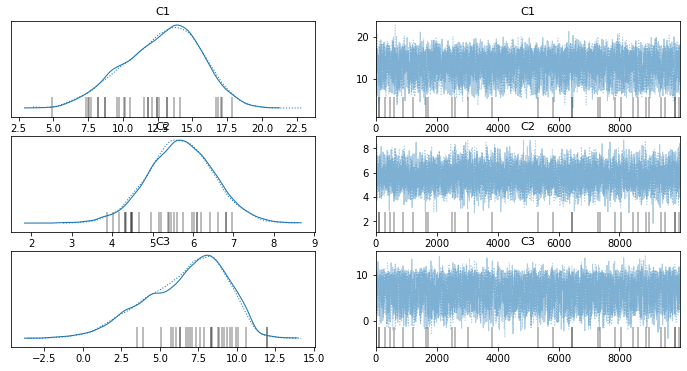

In [6]:
pm.traceplot(trace, var_names=['C1', 'C2', 'C3'])

Not bad. So, let's do something a bit more sophisticated. Eventually, it would be nice to create a PyMC3 BayesNet on the fly, reading in a specification (like PMML, for example!) and generating/running the theano model. The 'pythonic' way to do programmatic variable instantiation is to use a dictionary...and one of my other favorite packages is essentially a package for graphs built on dicts!
